In [25]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import joblib

import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


## PREPARAR DATOS

In [41]:
query = f"""SELECT *
FROM valores_climatologicos"""

In [43]:
database = "AEMET"

db = mysql.connector.connect( host = "localhost",
                          user = "root",
                          password = "nueva_contraseña",
                          database = database)

cursor = db.cursor()

cursor.execute(query)
column_names = cursor.column_names
data = cursor.fetchall()

data = pd.DataFrame(data = data, columns = column_names )

cursor.close()
db.close()

In [44]:
tmed = data.dropna()
tmed

,valores_climatologicos_id,fecha,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,...,racha,horaracha,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,indicativo_id,ciudad_id,provincia_id
3,4,2013-01-01,582,8.8,0.0,4.6,0 days 02:00:00,13.0,0 days 13:50:00,28.0,...,10.8,0 days 14:20:00,65.0,88.0,0 days 09:10:00,47.0,0 days 13:00:00,4,4,4
5,6,2013-01-01,88,11.1,0.0,5.1,0 days 00:40:00,17.1,0 days 14:00:00,24.0,...,10.6,0 days 08:30:00,56.0,79.0,0 days 06:20:00,40.0,0 days 13:20:00,6,6,6
8,9,2013-01-01,43,10.4,0.0,4.8,0 days 04:30:00,16.0,0 days 13:50:00,28.0,...,4.7,0 days 03:50:00,67.0,81.0,0 days 00:30:00,47.0,0 days 13:50:00,9,9,9
11,12,2013-01-01,870,3.0,3.2,-1.4,0 days 05:50:00,7.3,0 days 13:00:00,34.0,...,10.6,0 days 19:30:00,86.0,96.0,0 days 07:10:00,72.0,0 days 13:10:00,12,12,12
12,13,2013-01-01,785,6.6,0.0,1.9,0 days 23:59:00,11.4,0 days 13:50:00,28.0,...,9.7,0 days 14:00:00,80.0,93.0,0 days 23:59:00,69.0,0 days 12:40:00,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335987,7335988,2024-11-01,790,14.5,0.0,10.5,0 days 23:59:00,18.5,0 days 13:50:00,12.0,...,7.2,0 days 02:10:00,70.0,84.0,0 days 07:30:00,53.0,0 days 13:50:00,197,196,23
7335994,7335995,2024-11-01,87,18.6,3.0,16.8,0 days 07:00:00,20.5,0 days 11:50:00,10.0,...,5.6,0 days 08:30:00,91.0,100.0,0 days 00:30:00,73.0,0 days 14:00:00,226,224,51
7335995,7335996,2024-11-01,701,15.0,0.0,10.2,0 days 23:58:00,19.8,0 days 13:38:00,12.0,...,8.6,0 days 15:10:00,81.0,98.0,0 days 23:59:00,57.0,0 days 13:40:00,912,901,7
7335996,7335997,2024-11-01,2369,10.5,0.0,6.5,0 days 00:30:00,14.5,0 days 15:00:00,32.0,...,13.1,0 days 17:10:00,20.0,41.0,0 days 16:40:00,7.0,0 days 00:00:00,235,232,18


### Modelo RNN

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
tmed = scaler.fit_transform(tmed.values.reshape(-1, 1))# Normaliza tmed

joblib.dump(scaler, 'scaler.pkl')


# Crear secuencias de datos
def create_dataset(data, target, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Datos de entrada
        y.append(target[i + time_step, 0])    # tmed como objetivo
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(temperatures, tmed, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(SimpleRNN(25, return_sequences=True, input_shape=(X_train.shape[1], 1)))  
model.add(SimpleRNN(25))  
model.add(Dense(1))  # Capa de salida para la predicción de tmed

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6)

# Entrenamiento del modelo 
history = model.fit(X_train, y_train, epochs=100, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Hacer predicciones
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

NameError: name 'temperatures' is not defined

In [19]:
joblib.dump(model, 'modelo_RNN.pkl')

print("Modelo guardado con joblib")


Modelo guardado con joblib


Mean Absolute Error: 15.833566987992945
Mean Squared Error: 287.3748540602733


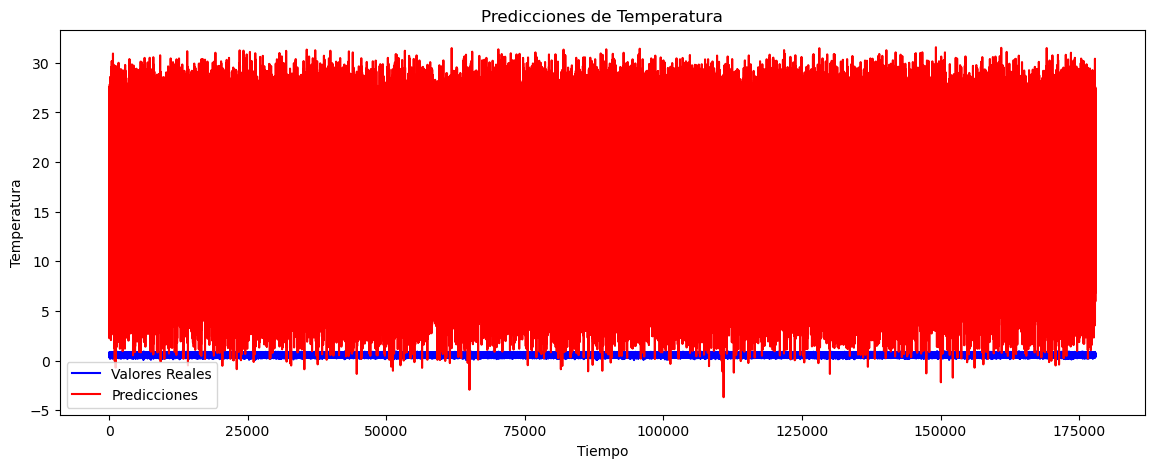

In [9]:
# Calcular métricas
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Visualización de resultados
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(predictions, label='Predicciones', color='red')
plt.title('Predicciones de Temperatura')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(predictions.history['loss'], label='Pérdida de Entrenamiento', color='orange')
plt.plot(predictions.history['val_loss'], label='Pérdida de Validación', color='green')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'history'

<Figure size 1400x500 with 0 Axes>

In [ ]:
### GUARDAR RESULTADOS 

results = pd.DataFrame({
    'Real': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
    'Predicción': predictions.flatten()
})


# Agregar las métricas como una nueva fila
metrics = pd.DataFrame({
    'Real': ['MAE', 'MSE'],
    'Predicción': [mae, mse]
})

# Concatenar los resultados y las métricas
final_results = pd.concat([results, metrics], ignore_index=True)

# Guardar el DataFrame en un archivo CSV
final_results.to_csv('resultados_predicciones_rnn.csv', index=False)

print("Resultados y métricas guardados en 'resultados_predicciones.csv'")

## Modelo LSTM

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - loss: 0.0086 - learning_rate: 0.0010
Epoch 2/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 3/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 4/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 5/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 6/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 7/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 8/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 9/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 10/15
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 11/15
11122/11122 ━━━

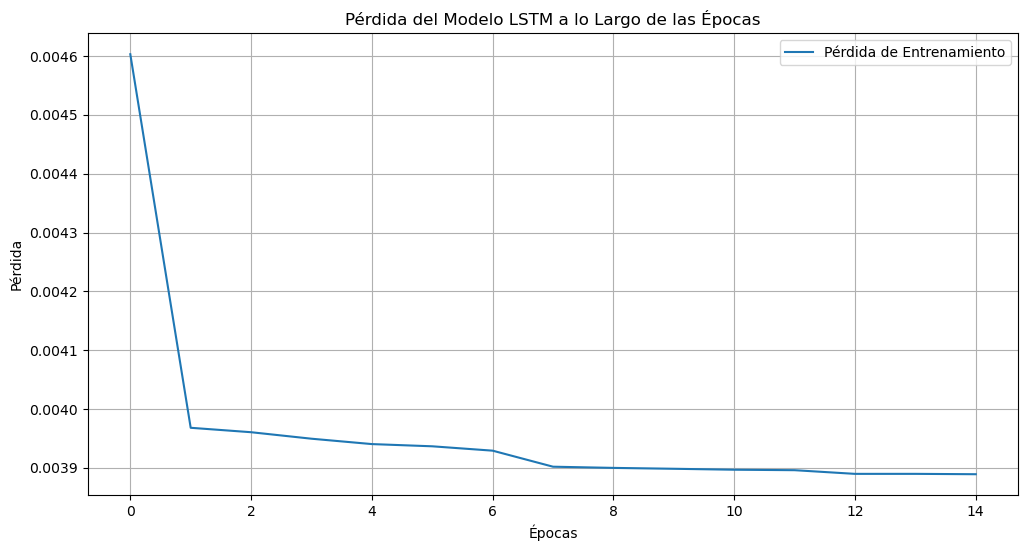

27805/27805 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0036
Pérdida del modelo: 0.0038865262176841497
27805/27805 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step
RMSE: 0.06234194515760736
R²: 0.7609301651692667


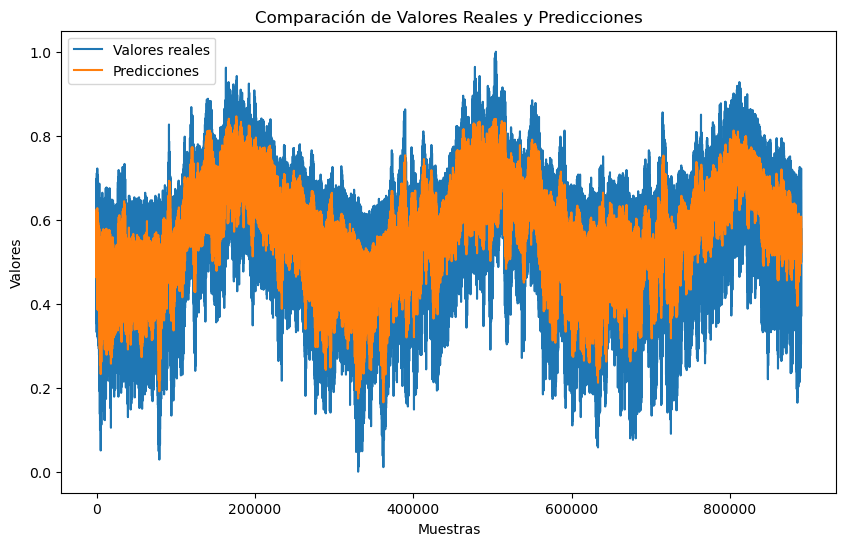

In [11]:
modelo_lstm = Sequential()
modelo_lstm.add(LSTM(25, input_shape=(X_train.shape[1], 1)))  
modelo_lstm.add(Dense(1))  
modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6)

# Entrenar el modelo y guardar el historial
historial = modelo_lstm.fit(X_train, y_train, epochs=15, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Visualizar las métricas
plt.figure(figsize=(12, 6))
plt.plot(historial.history['loss'], label='Pérdida de Entrenamiento')
plt.title('Pérdida del Modelo LSTM a lo Largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Evaluar el modelo
loss = modelo_lstm.evaluate(X, y)
print(f'Pérdida del modelo: {loss}')

# Obtener las predicciones
predicciones = modelo_lstm.predict(X)

# Calcular métricas adicionales
rmse = mean_squared_error(y, predicciones, squared=False)
r2 = r2_score(y, predicciones)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(y, label='Valores reales')
plt.plot(predicciones, label='Predicciones')
plt.title('Comparación de Valores Reales y Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()

In [12]:
### GUARDAR RESULTADOS 


results_lstm = pd.DataFrame({
    'Real': scaler.inverse_transform(y.reshape(-1, 1)).flatten(),
    'Predicción': scaler.inverse_transform(predicciones).flatten()
})

# Calcular métricas
mae = mean_absolute_error(y, predicciones)
mse = mean_squared_error(y, predicciones)

# Agregar las métricas como una nueva fila
metrics_lstm = pd.DataFrame({
    'Real': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Predicción': [mae, mse, rmse, r2]
})

# Concatenar los resultados y las métricas
final_results_lstm = pd.concat([results_lstm, metrics_lstm], ignore_index=True)

# Guardar el DataFrame en un archivo CSV
final_results_lstm.to_csv('resultados_predicciones_lstm.csv', index=False)

print("Resultados y métricas del modelo LSTM guardados en 'resultados_predicciones_lstm.csv'")

Resultados y métricas del modelo LSTM guardados en 'resultados_predicciones_lstm.csv'


In [17]:
joblib.dump(model, 'modelo_LSTM.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib
